# **Projek Akhir Praktikum Data Science**

> Analisis Sentimen Mengenai Vaksin COVID-19 Di Indonesia Menggunakan Metode Naive Bayes Classifier dan NLP Pada Sosial Media Twitter

**Oleh Kelompok 2 :**
1. Hazlan Muhammad Qodri (123190080) @hzlnqodrey
2. Elisia Dwi Rahayu (123190062) @elisiadwirahayu
3. Shania Septika Inayasari (123190055) @shaniainayasari

**Penjelasan Projek :**

Adapun pada penelitian menekankan kepada sentimen masyarakat terhadap mengenai vaksin COVID-19. Proses analisisnya akan dilakukan berdasarkan tweet yang menyertakan tagar vaksin dan pencarian di twitter dengan keyword vaksin covid 19.

## **1. Scraping Data from Twitter**

In [ ]:
%pip install snscrape

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

#### Query

In [ ]:
# Get All Covid Sentiment Data from January 1st, 2020 until November 1st, 2022
query = "covid since:2020-01-01 until:2022-11-01 lang:id"
limit = 2000 # limit 50k rows

In [ ]:
tweets = []

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == limit:
        break
    else:
        tweets.append([
            tweet.date,
            tweet.username,
            tweet.content
        ])

filename = 'tweets_covid_dataset_2k_raw_noindex.csv'
tweets_df = pd.DataFrame(tweets, columns=['Tanggal', 'Username', 'Text'])
tweets_df.to_csv(filename, index=False)
print('Scraping has completed!')

## **2. Wrangling Data** (Preprocessing)

In [ ]:
%pip install tweet-preprocessor
%pip install textblob
%pip install wordcloud
%pip install nltk

In [ ]:
import preprocessor as preproc
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import csv
import string
import pandas as pd
import numpy as np
import re

In [ ]:
# get data from dataset
data = pd.read_csv('https://raw.githubusercontent.com/hzlnqodrey/projek-akhir-prak-ds-sentimen-analisis-twitter-covid19-nlp-bayes/main/data_csv/tweets_covid_dataset_2k_raw_noindex.csv')

In [ ]:
data.info()

In [ ]:
data.sample(n=5)

##### 1. Case Folding

In [ ]:
data['Text'] = data['Text'].str.lower()

In [ ]:
print('Case Folding Result : \n')
data.sample(n=5)

In [ ]:
data.isnull().sum()

##### 2. Cleaning

In [ ]:
# cleaning overall
def preprocessing_data(x):
    return preproc.clean(x)

data['Text'] = data['Text'].apply(preprocessing_data)


In [ ]:
print('Cleaning Result : \n')
data.sample(n=5)

In [ ]:
# cleaning remove_comments_special
def remove_comments_special(text):
    # remove tab, new line, and back slice
    text = text.replace('\\t', " ").replace('\\n', " ").replace(
        '\\u', " ").replace('\\', " ").replace('.', " ")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(
        re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())
    # remove ascii decoded
    text = ' '.join(
        re.sub("amp; ", " ", text).split())
    text = ' '.join(
        re.sub("lt; ", " ", text).split())
    text = ' '.join(
        re.sub("gt; ", " ", text).split())
    # remove single char
    text = ' '.join(
        re.sub(r"\b[a-zA-Z]\b", " ", text).split())
    return text

data['Text'] = data['Text'].apply(remove_comments_special)

# remove symbol
def remove_symbol(text):
    text = ''.join(
        re.sub(r"[\!\@\#\$\%\^\&\*\(\)\?\,\"\|\:]+", "", text)
    )
    return text

data['Text'] = data['Text'].apply(remove_symbol)

# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))


print('Cleaning Result : \n')
data.sample(n=5)

##### 3. Tokenizing

In [ ]:
def tokenize_data(text):
    return word_tokenize(text)

data['Text_Clean'] = data['Text'].apply(tokenize_data)

In [ ]:
print('Tokenizing Result : \n')
data.sample(n=5)

##### 4. Filtering

In [ ]:
# Filtering | Singkatan Indo
normalizad_word = pd.read_csv(
    "https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/kamus_singkatan.csv", sep=";", header=None)
normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]


def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]


data['Text_Clean'] = data['Text_Clean'].apply(normalized_term)
data.head(5)

In [ ]:
# Filtering | Stop Word
list_stopwords = (['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'seperti', 'jika', 'jika', 'sehingga', 'mungkin', 'kembali', 'dan', 'ini', 'karena', 'oleh', 'saat', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'sebagai', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bahwa', 'atau', 'dengan', 'akan', 'juga', 'kalau', 'ada', 'terhadap', 'secara', 'agar', 'lain', 'jadi', 'yang ', 'sudah', 'sudah begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi',
                  'sementara', 'tetapi', 'apakah', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'juga', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'sebetulnya', 'setiap', 'sesuatu', 'pasti', 'saja', 'toh', 'ya', 'walau', 'apalagi', 'bagaimanapun', 'yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar', 'bikin', 'bilang', 'krn', 'nya', 'nih', 'sih', 'ah', 'ssh', 'om', 'ah', 'si', 'tau', 'tuh', 'utk', 'ya', 'cek', 'jd', 'aja', 't', 'nyg', 'hehe', 'pen', 'nan', 'loh', 'rt', '&amp', 'yah', 'ni', 'ret', 'za', 'nak', 'haa', 'zaa', 'maa', 'lg', 'eh', 'hmm', 'kali'])

list_stopwords = set(list_stopwords)


def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]


data['Text_Clean'] = data['Text_Clean'].apply(stopwords_removal)

In [ ]:
data.head(5)

In [ ]:
def sambungin_kata(text):
    text = ' '.join(text)
    return text

data['Text_Clean_Sambung'] = data['Text_Clean'].apply(sambungin_kata)

In [ ]:
data

In [ ]:
data.drop(['Text_Clean'], axis=1, inplace=True)

In [ ]:
data

## **2.1 Menejermah Tweet Clean hasil Preproc ke Bahasa Inggris** (Translating)

In [ ]:
%pip install googletrans==4.0.0rc1

In [ ]:
%pip install google-cloud-translate==2.0.1
%pip install --upgrade google-cloud-translate

In [ ]:
## NOTE: JIKA MEMAKAI GOOGLE TRANSLATE API WEBSITE
import pandas as pd
from googletrans import Translator

translator = Translator()

translated_word = []
new_row = []

data = data.reset_index()  # make sure indexes pair with number of rows

for index, row in data.iterrows():
    new_row.append(row['Text_Clean_Sambung'])

for per_row in new_row:
    out = translator.translate(per_row, dest='en')
    translated_word.append(out.text)

data.insert(loc=len(data.columns),
            column="text_english", value=translated_word)

print('Translating has completed!')

In [ ]:
## NOTE: JIKA MEMAKAI GOOGLE CLOUD TRANSLATE API
import os

from google.cloud import translate_v2

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"serviceKey.json"

translate_client = translate_v2.Client()

text = "Saya siapa dan kamu dimana"

target = "en"

output = translate_client.translate(text, target_language=target)

print(output)
print(output['translatedText'])

In [ ]:
# REAL IMPLEMENTATION
import os

from google.cloud import translate_v2

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"serviceKey.json"

translate_client = translate_v2.Client()
target = "en"

translated_word = []
new_row = []
data = data.reset_index()  # make sure indexes pair with number of rows

for index, row in data.iterrows():
    new_row.append(row['Text_Clean_Sambung'])

for per_row in new_row:
    output = translate_client.translate(per_row, target_language="en")
    translated_word.append(output['translatedText'])

data.insert(loc=len(data.columns),
            column="text_english", value=translated_word)

print('Translating has completed!')

In [ ]:
data.head(5)

In [ ]:
# up to csv
filename = "english_tweets_covid_dataset_2k.csv"
data.to_csv(filename, index=False)

## **2.2 Stemming**

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('punkt')
import string
import re

[nltk_data] Downloading package punkt to C:\Users\HAZLAN M
[nltk_data]     QODRI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
data = pd.read_csv('https://raw.githubusercontent.com/hzlnqodrey/projek-akhir-prak-ds-sentimen-analisis-twitter-covid19-nlp-bayes/main/data_csv/english_tweets_covid_dataset_2k.csv')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               2000 non-null   int64 
 1   Tanggal             2000 non-null   object
 2   Username            2000 non-null   object
 3   Text                2000 non-null   object
 4   Text_Clean_Sambung  2000 non-null   object
 5   text_english        2000 non-null   object
dtypes: int64(1), object(5)
memory usage: 93.9+ KB


In [48]:
data.drop(['index', 'Text'], axis=1, inplace=True)

In [49]:
# hapuskan symbol &#39; > ganti menjadi (')
# remove  &#39; symbol
def remove_symbol(text):
    text = ''.join(
        re.sub(r"[&#39;]+", "'", text)
    )
    return text

data['text_english'] = data['text_english'].apply(remove_symbol)

In [50]:
ps = PorterStemmer()

def stemming_data(text):
    return ps.stem(text)

data['text_english'] = data['text_english'].apply(stemming_data)

In [51]:
data.sample(n=5)

,Tanggal,Username,Text_Clean_Sambung,text_english
1294,2022-10-31 08:36:25+00:00,anaknya_mageran,valid phk covid pengusaha semua apa saja ruma...,valid phk covid entrepreneur all the houses ar...
1078,2022-10-31 10:00:06+00:00,KontanNews,update covid-19 indonesia oktober tambah kasus...,indonesia's october covid-1' update added new ...
1886,2022-10-31 04:51:21+00:00,Michlans,orang denial long covid kok suruh orang banya...,why do people in denial long covid tell people...
1,2022-10-31 23:58:49+00:00,s_h_y_l_l_a,segala sakit disalahin vaksin covid lieur,all illnesses are blamed for the covid lieur v...
680,2022-10-31 12:38:16+00:00,radarbangsa_com,update data covid indonesia positif sembuh,update on positive indonesian covid data recov


## **3. Sentiment Analysis dengan NLP (TextBlob)**

In [52]:
data_tweet = list(data['text_english'])
polaritas = 0

tot_positif = tot_negatif = tot_netral = total = 0
status = []

for i, tweet in enumerate(data_tweet):
    analysis = TextBlob(tweet)
    polaritas += analysis.polarity

    if analysis.sentiment.polarity > 0.0:
        tot_positif += 1
        status.append('Positif')
    elif analysis.sentiment.polarity == 0.0:
        tot_netral += 1
        status.append('Netral')
    else: 
        tot_negatif += 1
        status.append('Negatif')
        
    total += 1

print(f'Hasil Analisis Data:\nPositif = {tot_positif}\nNetral = {tot_netral}\nNegatif = {tot_negatif}')
print(f'\nTotal Data : {total}')



Hasil Analisis Data:
Positif = 775
Netral = 705
Negatif = 520

Total Data : 2000


In [53]:
# tambahkan status sentiment ke dataframe
status = pd.DataFrame({'klasifikasi': status})
data['klasifikasi'] = status
data.sample(n=5)

,Tanggal,Username,Text_Clean_Sambung,text_english,klasifikasi
0,2022-10-31 23:59:58+00:00,lordkuyang,dulu barat upn warung kayuh bambai bumbu haban...,"in the past, the western upn stall, the caulif...",Positif
1,2022-10-31 23:58:49+00:00,s_h_y_l_l_a,segala sakit disalahin vaksin covid lieur,all illnesses are blamed for the covid lieur v...,Netral
2,2022-10-31 23:58:14+00:00,kunsh72,bukankah kamu dulu bagian rezim setelah terdep...,didn't you used to be part of the regime after...,Positif
3,2022-10-31 23:57:58+00:00,erni076,saya kan ganti lama dulu covid menyerang sudah...,"i changed it a long time ago, when covid attac...",Negatif
4,2022-10-31 23:57:38+00:00,KENTUSIAS,terus masku kena covid kek sudah endemi masi ae,then my mask got covid kek it's already endemi...,Netral


#### **3.1 Word Cloud**

In [54]:
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud) 
    plt.axis("off")

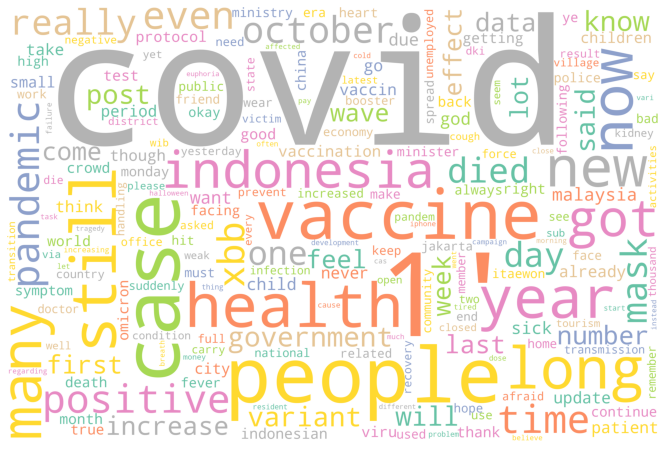

In [55]:
all_words = ' '.join([tweets for tweets in data['text_english']])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=3, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(all_words)
plot_cloud(wordcloud)

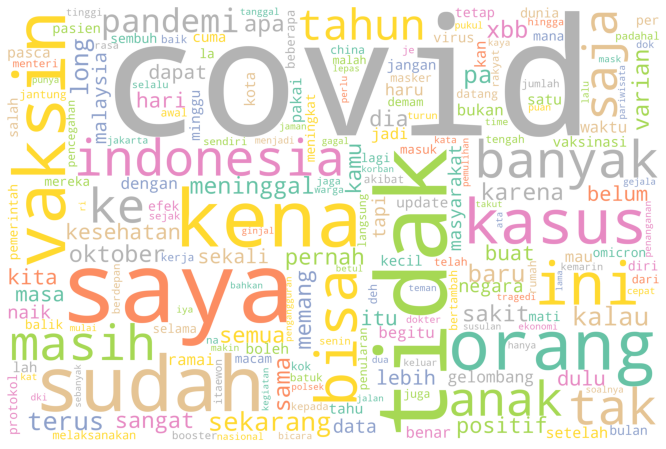

In [56]:
all_words = ' '.join([tweets for tweets in data['Text_Clean_Sambung']])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=3, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(all_words)
plot_cloud(wordcloud)

#### **3.2 Pie Chart**

In [57]:
def show_pie(label, data, legend_title):
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(aspect='equal'))

    labels = [x.split()[-1] for x in label]

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}% ({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"))

    ax.legend(wedges, labels,
              title=legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=10, weight="bold")
    plt.show()


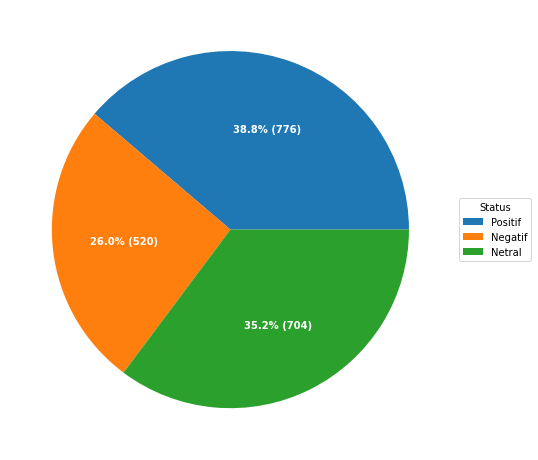

In [59]:
label = ['Positif', 'Negatif', 'Netral']
count_data = [tot_positif+1, tot_negatif+1, tot_netral]

show_pie(label, count_data, "Status")

**Kesimpulan :** 

Hasil dari Sentiment Analysis menggunakan NLP library TextBlob adalah: persentase sentimen masyarakat tentang menanggapi topik COVID-19 selama periode Oktober s.d. November yaitu 38% Positif, 35% Netral, dan 26% Negatif 

## **4. Klasifikasi Data Tweets dengan Naive Bayes** (Classification)

In [ ]:
nltk.download('punkt')

In [62]:
dataset = data.drop(['Tanggal', 'Username', 'Text_Clean_Sambung'], axis=1, inplace=False)
dataset = [tuple(x) for x in dataset.to_records(index=False)]

In [ ]:
import random

set_positif = []
set_negatif = [] 
set_netral = []

for n in dataset:
    if(n[1] == 'Positif'):
      set_positif.append(n)
    elif(n[1] == 'Negatif'):
      set_negatif.append(n)
    else: 
      set_netral.append(n)

set_positif = random.sample(set_positif, k=int(len(set_positif)/2))
set_negatif = random.sample(set_negatif, k=int(len(set_negatif)/2))
set_netral = random.sample(set_netral, k=int(len(set_netral)/2))